#Long-Short-Term using Google's Word2Vec

###Reference
data representation techniques (Tokenizer() class, Word2Vec and GloVe embedding): 'Deep Learning with Python' by Francois Chollet, 'Implement neural networks with Keras on Theano and TensorFlow' by Sujit Pal et al. 

spam detection example: https://towardsdatascience.com/nlp-spam-detection-in-sms-text-data-using-deep-learning-b8632db85cc8

recurrent layers: https://keras.io/api/layers/recurrent_layers/

###Mounting to Google Drive

In [ ]:
#connecting gdrive into the google colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Import Libraries

In [ ]:
# import libraries
import pandas as pd
import gensim
import nltk
nltk.download('punkt')
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

from keras.constraints import max_norm
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import Activation, Dense, Dropout, Flatten, SimpleRNN
from keras.initializers import Constant

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.utils import plot_model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


####Load the Dataset


In [ ]:
#load the dataset - change file path 
data=pd.read_csv("/content/gdrive/MyDrive/DepressionDataFinal2Processed.csv")
data = data.astype(str)
data["Target"] = data["Target"].astype(str).astype(int)
data.head()

,Id,Text,Target
0,2.85e+17,one thing love life mother one ever come mine,1
1,2.9e+17,want perfect want happy,0
2,2.86e+17,mom hates dad hates today sucks fword life tho,0
3,2.86e+17,hate hate life,0
4,2.86e+17,feel good,1


In [ ]:
data.columns

Index(['Id', 'Text', 'Target'], dtype='object')

### Train, Val, Test split --> 60%, 20%, 20% 

In [ ]:
# train, val, test split --> 60%, 20%, 20% 
# x_train is the training data set
# y_test is the corresponding labels to x_train 
# x_test is the test dataset 
# y_test is the corresponding label to x_test 
x_train, x_test, y_train, y_test = train_test_split(data, data.Target, test_size=0.2, random_state=1)
# # 0.25 x 0.8 = 0.2
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) 

### Constants

In [ ]:
max_len = 20
EMBEDDING_DIM = 300

### Tokenize tweets using Tokenizer()

In [ ]:
# Tokenizer API used to encode each word as a number 
vect = Tokenizer()
total_reviews = x_train + x_test + x_val
vect.fit_on_texts(total_reviews)

### Turn the Vectorized Tokens into Sequences of Integers


In [ ]:
encoded_docs_train = vect.texts_to_sequences(x_train)
encoded_docs_test = vect.texts_to_sequences(x_test)
encoded_docs_val = vect.texts_to_sequences(x_val)

### Padding and Making all the Sequences the same Length

In [ ]:
# pad sequence
padded_docs_train = pad_sequences(encoded_docs_train, maxlen=max_len, padding="post")
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_len, padding="post")
padded_docs_val = pad_sequences(encoded_docs_val, maxlen=max_len, padding="post")

### Find number of tokens in List

In [ ]:
# add tokens in text column in a list 
# find number of tokens in list
review_lines = list()
lines = data["Text"].values.tolist()
for line in lines:
  tokens = word_tokenize(line)
  review_lines.append(tokens)

In [ ]:
  len(review_lines)

8815

### Train Google's Word2Vec model on the vocabulary 

In [ ]:
import gensim
# https://code.google.com/archive/p/word2vec/#! - The pre-trained Word2Vec model trained on Google News dataset 
#can be found of this link (download 'GoogleNews-vectors-negative300.bin.gz')
filename = '/content/gdrive/MyDrive/GoogleVec.bin'
model = gensim.models.KeyedVectors.load_word2vec_format(filename, binary=True)

In [ ]:
model.most_similar_cosmul(positive=['king', 'woman'], negative=['man'])

[('queen', 0.9314123392105103),
 ('monarch', 0.858533501625061),
 ('princess', 0.8476566076278687),
 ('Queen_Consort', 0.8150269985198975),
 ('queens', 0.8099815249443054),
 ('crown_prince', 0.808997631072998),
 ('royal_palace', 0.8027306795120239),
 ('monarchy', 0.801961362361908),
 ('prince', 0.800979733467102),
 ('empress', 0.7958388328552246)]

### Tokenize, Vectorize, turn it into sequence and Pad again

In [ ]:
# vectorise tweets 
vect = Tokenizer()
vect.fit_on_texts(review_lines)
sequences = vect.texts_to_sequences(review_lines)

In [ ]:
word_index = vect.word_index
print (len(word_index))

1987


In [ ]:
review_pad = pad_sequences(sequences, maxlen = max_len)
sentiment = data["Target"].values

### Prepare Embedding Matrix

In [ ]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= max_len:
        continue
    if word in model.vocab:
      embedding_vector = model[word]
      embedding_vector = np.array(embedding_vector)
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(1988, 300)


In [ ]:
print(num_words)

1988


### Build and compile DL Model

In [ ]:
model = Sequential()
embedding_layer = Embedding(num_words, EMBEDDING_DIM, input_length= max_len, weights = [embedding_matrix])
# Configuring the parameters
model.add(embedding_layer)
model.add(layers.LSTM(45))
model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 300)           596400    
_________________________________________________________________
lstm (LSTM)                  (None, 45)                62280     
_________________________________________________________________
dropout (Dropout)            (None, 45)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 46        
Total params: 658,726
Trainable params: 658,726
Non-trainable params: 0
_________________________________________________________________


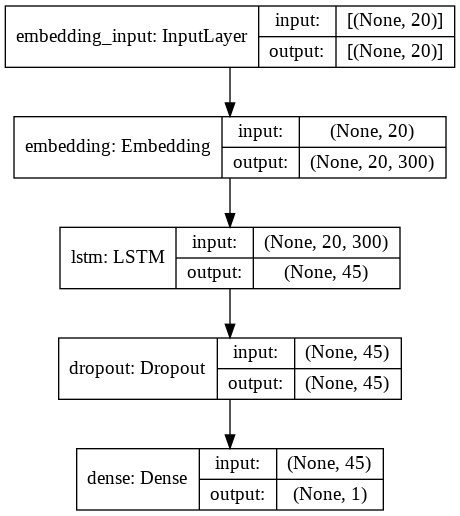

In [ ]:
# plot NN model 
plot_model(model, to_file='/content/gdrive/MyDrive/mlp-mnist.png', show_shapes=True)

### Split Validation Dataset

In [ ]:
validation_split = 0.2 
indices = np.arange(review_pad.shape[0])
print(np.random.shuffle(indices))
review_pad = review_pad[indices]
sentiment = sentiment[indices]
num_validation_samples = int(validation_split * review_pad.shape[0])
print(num_validation_samples)

None
1763


In [ ]:
padded_docs_train = review_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
padded_docs_cv = padded_docs_train[-num_validation_samples:]
y_val = y_train[-num_validation_samples:]
padded_docs_test = review_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

In [ ]:
# compile the model 
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.4)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(padded_docs_train, y_train,
                    epochs=50, batch_size=128, 
                    validation_data = (padded_docs_cv, y_val)
                    )
model.save('model.h5')

Epoch 1/50
56/56 [==============================] - 6s 72ms/step - loss: 0.5762 - accuracy: 0.6883 - val_loss: 0.3389 - val_accuracy: 0.8429
Epoch 2/50
56/56 [==============================] - 3s 54ms/step - loss: 0.2695 - accuracy: 0.9010 - val_loss: 0.2042 - val_accuracy: 0.9229
Epoch 3/50
56/56 [==============================] - 3s 54ms/step - loss: 0.1921 - accuracy: 0.9371 - val_loss: 0.1710 - val_accuracy: 0.9376
Epoch 4/50
56/56 [==============================] - 3s 54ms/step - loss: 0.1619 - accuracy: 0.9467 - val_loss: 0.1411 - val_accuracy: 0.9444
Epoch 5/50
56/56 [==============================] - 3s 52ms/step - loss: 0.1483 - accuracy: 0.9511 - val_loss: 0.1253 - val_accuracy: 0.9580
Epoch 6/50
56/56 [==============================] - 3s 52ms/step - loss: 0.1294 - accuracy: 0.9571 - val_loss: 0.1162 - val_accuracy: 0.9597
Epoch 7/50
56/56 [==============================] - 3s 52ms/step - loss: 0.1206 - accuracy: 0.9639 - val_loss: 0.1044 - val_accuracy: 0.9643
Epoch 8/50
56

### Evaluate the Model


In [ ]:
model.evaluate(padded_docs_test, y_test)

56/56 [==============================] - 0s 6ms/step - loss: 0.3225 - accuracy: 0.9285


[0.32249966263771057, 0.9285309314727783]

In [ ]:
x_test.head()

,Id,Text,Target
2143,2.9e+17,social life,0
2181,2.9e+17,good friends,1
4425,2.85e+17,listening love cause hate life,0
2577,2.9e+17,love never gets bored,1
2213,2.9e+17,best boyfriend ever,1


In [ ]:
pred = model.predict_classes(padded_docs_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
import numpy as np
text = x_test["Text"]
#pred = np.argmax(pred, axis = 1)

In [ ]:
for i in range(1763):
  print("Text: ",x_test["Text"].iloc[i], "-->", "Actual Label: ", x_test["Target"].iloc[i], "-->", "Predicted: ", pred[i])

Text:  social life --> Actual Label:  0 --> Predicted:  [1]
Text:  good friends --> Actual Label:  1 --> Predicted:  [1]
Text:  listening love cause hate life --> Actual Label:  0 --> Predicted:  [0]
Text:  love never gets bored --> Actual Label:  1 --> Predicted:  [0]
Text:  best boyfriend ever --> Actual Label:  1 --> Predicted:  [1]
Text:  wow suck --> Actual Label:  0 --> Predicted:  [0]
Text:  life series unfounate fworded events --> Actual Label:  0 --> Predicted:  [0]
Text:  god bless --> Actual Label:  1 --> Predicted:  [1]
Text:  yes i √ºber sad --> Actual Label:  0 --> Predicted:  [0]
Text:  i ame life i loving every single moment --> Actual Label:  1 --> Predicted:  [1]
Text:  i feeling great --> Actual Label:  1 --> Predicted:  [0]
Text:  i made like worst mistakes ever --> Actual Label:  0 --> Predicted:  [0]
Text:  love life --> Actual Label:  1 --> Predicted:  [0]
Text:  fword life --> Actual Label:  0 --> Predicted:  [0]
Text:  new resolution drink life fword terrible -

### Predict on Unseen Data 

In [ ]:
nd1 = ["i am the happiest person in this world"]
nd2 = ['i am excited']
nd3 = ['i would not change the past if I could']
nd4 = ['i get everything i want']
nd5 = ['everyday of my life is a celebration']
nd6 = ['my life is blessed']
nd7 = ['i feel complete']
nd8 = ['thank you god']
nd9 = ['i love my family']
nd10 = ['i am in a great mood']
nd11 = ['i never feel sad']   
nd12 = ['i hate chocolate']         

nd1pad = vect.texts_to_sequences(nd1)
nd1pad = pad_sequences(nd1pad, maxlen=9, padding='post')
prednd1 = model.predict_classes(nd1pad).item()
#prednd1a = (model.predict(nd1pad) > 0.5).astype("int32")
#prednd1c = np.argmax(prednd1)
#print(prednd1a, prednd1b, prednd1c)


nd2pad = vect.texts_to_sequences(nd2)
nd2pad = pad_sequences(nd2pad, maxlen=3, padding='post')
prednd2 = model.predict_classes(nd2pad).item()


nd3pad = vect.texts_to_sequences(nd3)
nd3pad = pad_sequences(nd3pad, maxlen=9, padding='post')
prednd3 = model.predict_classes(nd3pad).item()

nd4pad = vect.texts_to_sequences(nd4)
nd4pad = pad_sequences(nd4pad, maxlen=5, padding='post')
prednd4 = model.predict_classes(nd4pad).item()

nd5pad = vect.texts_to_sequences(nd5)
nd5pad = pad_sequences(nd5pad, maxlen=7, padding='post')
prednd5 = model.predict_classes(nd5pad).item()

nd6pad = vect.texts_to_sequences(nd6)
nd6pad = pad_sequences(nd6pad, maxlen=4, padding='post')
prednd6 = model.predict_classes(nd6pad).item()


nd7pad = vect.texts_to_sequences(nd7)
nd7pad = pad_sequences(nd7pad, maxlen=3, padding='post')
prednd7 = model.predict_classes(nd7pad).item()

nd8pad = vect.texts_to_sequences(nd8)
nd8pad = pad_sequences(nd8pad, maxlen=3, padding='post')
prednd8 = model.predict_classes(nd8pad).item()

nd9pad = vect.texts_to_sequences(nd9)
nd9pad = pad_sequences(nd9pad, maxlen=4, padding='post')
prednd9 = model.predict_classes(nd9pad).item()

nd10pad = vect.texts_to_sequences(nd10)
nd10pad = pad_sequences(nd10pad, maxlen=8, padding='post')
prednd10 = model.predict_classes(nd10pad).item()

nd11pad = vect.texts_to_sequences(nd11)
nd11pad = pad_sequences(nd11pad, maxlen=4, padding='post')
prednd11 = model.predict_classes(nd11pad).item()

nd12pad = vect.texts_to_sequences(nd12)
nd12pad = pad_sequences(nd12pad, maxlen=3, padding='post')
prednd12 = model.predict_classes(nd12pad).item()
#prednd12 = (model.predict(nd12pad) > 0.5).astype("int32")


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
print("Text: ",nd1, "-->", "Actual Label: ", "1", "-->", "Predicted: ", prednd1)
print("Text: ",nd2, "-->", "Actual Label: ", "1", "-->", "Predicted: ", prednd2)
print("Text: ",nd3, "-->", "Actual Label: ", "1", "-->", "Predicted: ", prednd3)
print("Text: ",nd4, "-->", "Actual Label: ", "1", "-->", "Predicted: ", prednd4)
print("Text: ",nd5, "-->", "Actual Label: ", "1", "-->", "Predicted: ", prednd5)
print("Text: ",nd6, "-->", "Actual Label: ", "1", "-->", "Predicted: ", prednd6)
print("Text: ",nd7, "-->", "Actual Label: ", "1", "-->", "Predicted: ", prednd7)
print("Text: ",nd8, "-->", "Actual Label: ", "1", "-->", "Predicted: ", prednd8)
print("Text: ",nd9, "-->", "Actual Label: ", "1", "-->", "Predicted: ", prednd9)
print("Text: ",nd10, "-->", "Actual Label: ", "1", "-->", "Predicted: ", prednd10)
print("Text: ",nd11, "-->", "Actual Label: ", "1", "-->", "Predicted: ", prednd11)
print("Text: ",nd12, "-->", "Actual Label: ", "1", "-->", "Predicted: ", prednd12)

Text:  ['i am the happiest person in this world'] --> Actual Label:  1 --> Predicted:  1
Text:  ['i am excited'] --> Actual Label:  1 --> Predicted:  0
Text:  ['i would not change the past if I could'] --> Actual Label:  1 --> Predicted:  0
Text:  ['i get everything i want'] --> Actual Label:  1 --> Predicted:  1
Text:  ['everyday of my life is a celebration'] --> Actual Label:  1 --> Predicted:  0
Text:  ['my life is blessed'] --> Actual Label:  1 --> Predicted:  1
Text:  ['i feel complete'] --> Actual Label:  1 --> Predicted:  1
Text:  ['thank you god'] --> Actual Label:  1 --> Predicted:  1
Text:  ['i love my family'] --> Actual Label:  1 --> Predicted:  1
Text:  ['i am in a great mood'] --> Actual Label:  1 --> Predicted:  1
Text:  ['i never feel sad'] --> Actual Label:  1 --> Predicted:  0
Text:  ['i hate chocolate'] --> Actual Label:  1 --> Predicted:  0


In [ ]:
d1 = ['i have lost in life']
d2 = ['why do i have to be sad']
d3 = ['i have never been so disappointed in life']
d4 = ['i feel like crying'] 
d5 = ['i hate the world'] 
d6 = ['why is everything so hard'] 
d7 = ['i feel miserable']
d8 = ['i live in a terrible place'] 
d9 = ['i cry all day'] 
d10 = ['i am not lucky nor blessed']
d11 = ['nobody loves me']
d12 = ['i am unlucky']         

d1pad = vect.texts_to_sequences(d1)
d1pad = pad_sequences(nd1pad, maxlen=6, padding='post')
#prednd1 = (model.predict(nd1pad) > 0.5).astype("int32")
predd1 = model.predict_classes(d1pad).item()


d2pad = vect.texts_to_sequences(d2)
d2pad = pad_sequences(d2pad, maxlen=7, padding='post')
predd2 = model.predict_classes(d2pad).item()

d3pad = vect.texts_to_sequences(d3)
d3pad = pad_sequences(d3pad, maxlen=8, padding='post')
predd3 = model.predict_classes(d3pad).item()

d4pad = vect.texts_to_sequences(d4)
d4pad = pad_sequences(d4pad, maxlen=4, padding='post')
predd4 = model.predict_classes(d4pad).item()

d5pad = vect.texts_to_sequences(d5)
d5pad = pad_sequences(d5pad, maxlen=4, padding='post')
predd5 = model.predict_classes(d5pad)
predd5 = np.argmax(predd5)

d6pad = vect.texts_to_sequences(d6)
d6pad = pad_sequences(d6pad, maxlen=5, padding='post')
predd6 = model.predict_classes(d6pad).item()

d7pad = vect.texts_to_sequences(d7)
d7pad = pad_sequences(d7pad, maxlen=3, padding='post')
predd7 = model.predict_classes(d7pad).item()

d8pad = vect.texts_to_sequences(d8)
d8pad = pad_sequences(d8pad, maxlen=4, padding='post')
predd8 = model.predict_classes(d8pad).item()

d9pad = vect.texts_to_sequences(d9)
d9pad = pad_sequences(d9pad, maxlen=4, padding='post')
predd9 = model.predict_classes(d9pad).item()

d10pad = vect.texts_to_sequences(d10)
d10pad = pad_sequences(d10pad, maxlen=6, padding='post')
predd10 = model.predict_classes(d10pad).item()

d11pad = vect.texts_to_sequences(d11)
d11pad = pad_sequences(d11pad, maxlen=3, padding='post')
predd11 = model.predict_classes(d11pad).item()

d12pad = vect.texts_to_sequences(d12)
d12pad = pad_sequences(d12pad, maxlen=5, padding='post')
predd12 = model.predict_classes(d12pad).item()


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
print("Text: ",d1, "-->", "Actual Label: ", "0", "-->", "Predicted: ", predd1)
print("Text: ",d2, "-->", "Actual Label: ", "0", "-->", "Predicted: ", predd2)
print("Text: ",d3, "-->", "Actual Label: ", "0", "-->", "Predicted: ", predd3)
print("Text: ",d4, "-->", "Actual Label: ", "0", "-->", "Predicted: ", predd4)
print("Text: ",d5, "-->", "Actual Label: ", "0", "-->", "Predicted: ", predd5)
print("Text: ",d6, "-->", "Actual Label: ", "0", "-->", "Predicted: ", predd6)
print("Text: ",d7, "-->", "Actual Label: ", "0", "-->", "Predicted: ", predd7)
print("Text: ",d8, "-->", "Actual Label: ", "0", "-->", "Predicted: ", predd8)
print("Text: ",d9, "-->", "Actual Label: ", "0", "-->", "Predicted: ", predd9)
print("Text: ",d10, "-->", "Actual Label: ", "0", "-->", "Predicted: ", predd10)
print("Text: ",d11, "-->", "Actual Label: ", "0", "-->", "Predicted: ", predd11)
print("Text: ",d12, "-->", "Actual Label: ", "0", "-->", "Predicted: ", predd12)

Text:  ['i have lost in life'] --> Actual Label:  0 --> Predicted:  1
Text:  ['why do i have to be sad'] --> Actual Label:  0 --> Predicted:  0
Text:  ['i have never been so disappointed in life'] --> Actual Label:  0 --> Predicted:  0
Text:  ['i feel like crying'] --> Actual Label:  0 --> Predicted:  0
Text:  ['i hate the world'] --> Actual Label:  0 --> Predicted:  0
Text:  ['why is everything so hard'] --> Actual Label:  0 --> Predicted:  0
Text:  ['i feel miserable'] --> Actual Label:  0 --> Predicted:  0
Text:  ['i live in a terrible place'] --> Actual Label:  0 --> Predicted:  0
Text:  ['i cry all day'] --> Actual Label:  0 --> Predicted:  0
Text:  ['i am not lucky nor blessed'] --> Actual Label:  0 --> Predicted:  1
Text:  ['nobody loves me'] --> Actual Label:  0 --> Predicted:  1
Text:  ['i am unlucky'] --> Actual Label:  0 --> Predicted:  0


In [ ]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

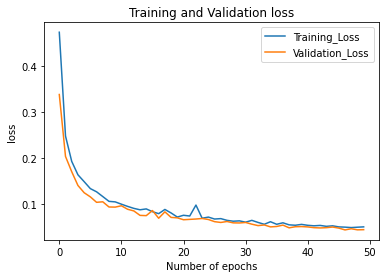

In [ ]:

from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

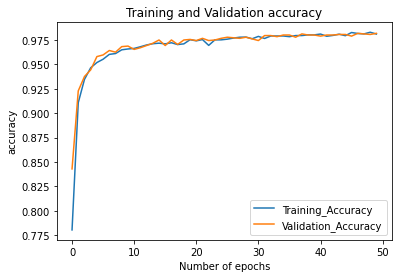

In [ ]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

### Metrics

In [ ]:
#pred = model.predict(padded_docs_test)
#pred = pred.round()
cm = confusion_matrix(y_test, pred)
print(cm)

[[764  72]
 [ 54 873]]


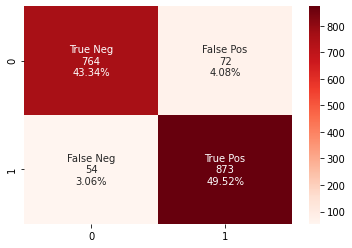

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Reds')

In [ ]:
print(classification_report(y_test,pred))
print("Accuracy: ", accuracy_score(y_test, pred))
print("F1: ", f1_score(y_test, pred))
print("Precision: ", precision_score(y_test, pred))
print("Recall: ", recall_score(y_test, pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       836
           1       0.92      0.94      0.93       927

    accuracy                           0.93      1763
   macro avg       0.93      0.93      0.93      1763
weighted avg       0.93      0.93      0.93      1763

Accuracy:  0.9285309132161089
F1:  0.9326923076923078
Precision:  0.9238095238095239
Recall:  0.941747572815534
